# Lab 5

# Кластеризация (k-средних, иерархическая)

## Загрузка данных

In [4]:
import pandas as pd
import numpy as np

data = pd.read_csv('iris.data', header=None)
no_labeled_data = data.drop(4, axis=1)

## K-means

Проведем кластеризацию методов k-средних:

In [5]:
from sklearn.cluster import KMeans

k_means = KMeans(init='k-means++', n_clusters=3, n_init=15)
k_means.fit(no_labeled_data)


KMeans(n_clusters=3, n_init=15)

Получим центры кластеров и определим какие наблюдения в какой кластер попали

In [6]:
from sklearn.metrics.pairwise import pairwise_distances_argmin

k_means_cluster_centers = k_means.cluster_centers_
k_means_labels = pairwise_distances_argmin(no_labeled_data,
k_means_cluster_centers)


Построим результаты классификации для признаков попарно (1 и 2, 2 и 3, 3 и 4)


[<AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]


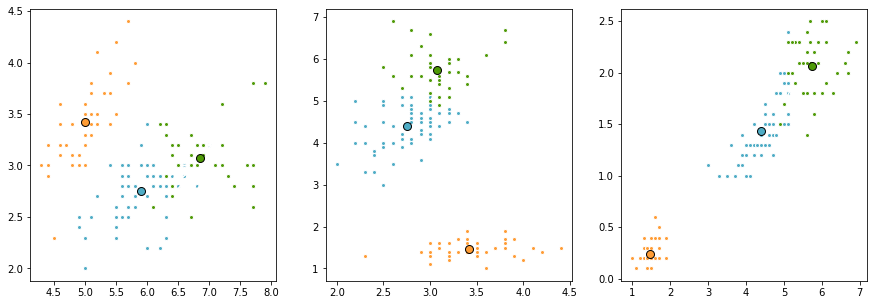

In [7]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (15, 5)

f, ax = plt.subplots(1, 3)

colors = ['#4EACC5', '#FF9C34', '#4E9A06']

print(ax)

for i in range(3):
    my_members = k_means_labels == i
    cluster_center = k_means_cluster_centers[i]
    for j in range(3):
        ax[j].plot(
            no_labeled_data[my_members][j],
            no_labeled_data[my_members][j+1],
            'w',
            markerfacecolor=colors[i],
            marker='o',
            markersize=4
        )
        
        ax[j].plot(
            cluster_center[j],
            cluster_center[j+1],
            'o',
            markerfacecolor=colors[i],
            markeredgecolor='k',
            markersize=8
        )
        
plt.show()


Наилучшее разделение было произведено по 1 и 2 признаку, так как для других признаков, как видно из графиков, количество кластеров лучше было взять 2, 
а не 3. Это субъективная оценка "наг глаз", для оценки лучше использовать более объективный метод - подсчет ошибки в зависимости от объема кластера.

`n_init` - это количество раз, когда изначальные позиции центроидов будут инициализированы с разными сидами. Чем больше, те результат (в теории) более точный (т.е. не зависисм от случайности). Особенно это важно, если в качестве метода инициализации был выбран `random`, а не `kmeans++`.

Уменьшим размерность данных до 2 используя метод главных компонент и нарисуем
карту для всей области значений, на которой каждый кластер занимает определенную
область со своим цветом


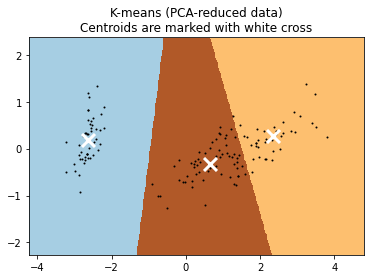

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(no_labeled_data)

k_means_r = KMeans(init='k-means++', n_clusters=3, n_init=15)
k_means_r.fit(reduced_data)

h = .02
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = k_means_r.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.figure(figsize=(6, 4))
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')
           
plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
centroids = k_means_r.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

pass

Исследуем работу алгоритма k-средних при различных параметрах init. Сначала надо
выполнить несколько раз с параметров 'random', затем для вручную выбранных точек.


/home/gikari/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1035: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/home/gikari/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1035: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/home/gikari/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1035: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


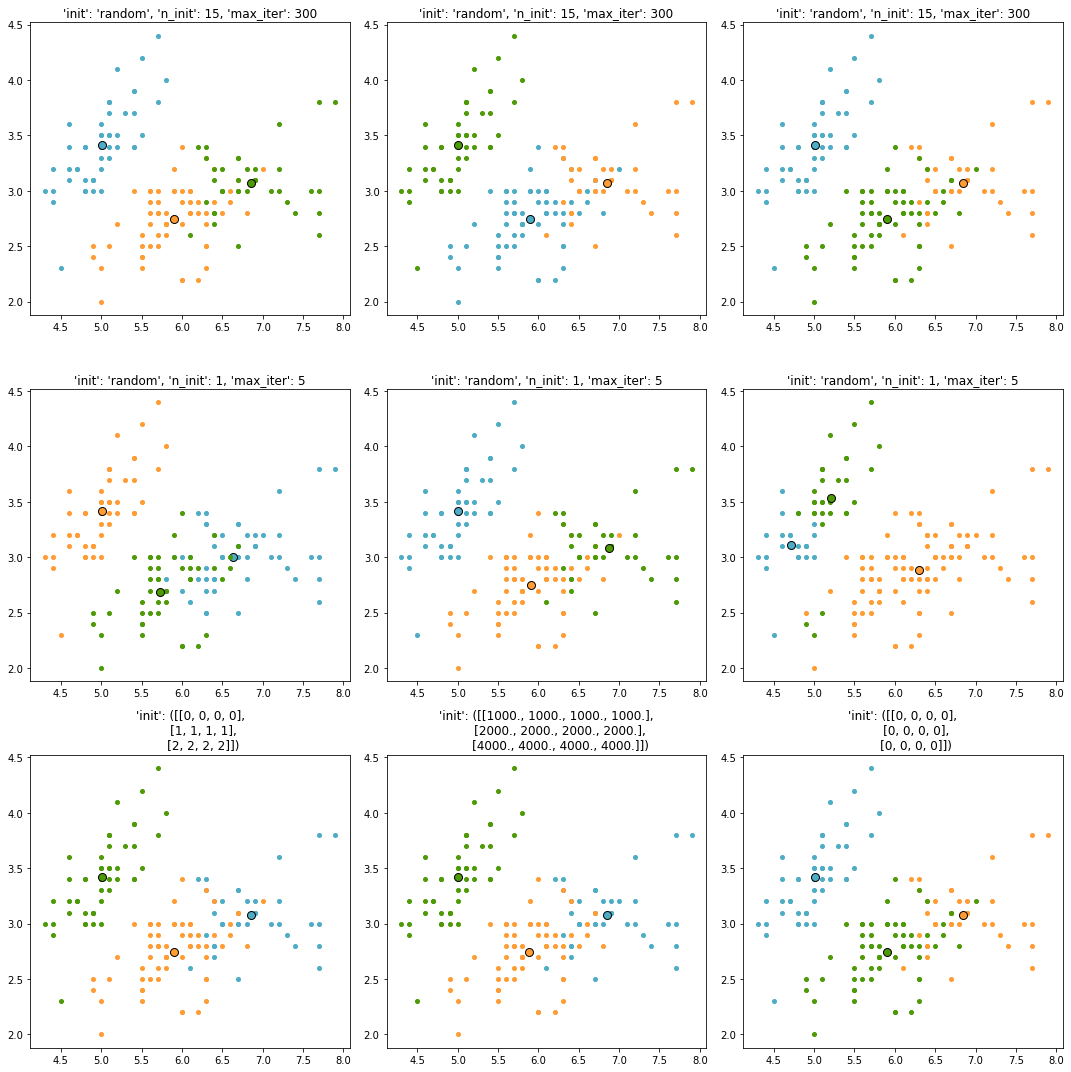

In [9]:
PARAMS = np.array([
    [
        { 'init': 'random', 'n_init': 15, 'max_iter': 300 }
    ] * 3,
    [
        { 'init': 'random', 'n_init': 1, 'max_iter': 5 }
    ] * 3,
    [
        { 'init': np.array([[0, 0, 0, 0], [1, 1, 1, 1], [2, 2, 2, 2]]) },
        { 'init': np.array([[1e3, 1e3, 1e3, 1e3], [2e3, 2e3, 2e3, 2e3], [4e3, 4e3, 4e3, 4e3]]) },
        { 'init': np.array([[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]) }
    ]
])

# test_kmeans(init='random', n_init=15, max_iter=300)

fig, axes = plt.subplots(*PARAMS.shape, figsize=(15, 15))

V = 0

for x in range(PARAMS.shape[0]):
    for y in range(PARAMS.shape[1]):
        km = KMeans(n_clusters=3, **PARAMS[x][y])
        km.fit(no_labeled_data)
        
        centers = km.cluster_centers_
        labels = pairwise_distances_argmin(no_labeled_data, centers)
        axes[x][y].set_title(str(PARAMS[x][y]).replace('{', '').replace('}', '').replace('array', ''))
        for i in range(3):
            my_members = labels == i
            center = centers[i]
            axes[x][y].plot(
                no_labeled_data.loc[my_members][V],
                no_labeled_data[my_members][V + 1],
                markerfacecolor=colors[i],
                markeredgecolor=colors[i],
                marker='o',
                markersize=4,
                lw=0
            )
            axes[x][y].plot(
                center[V], center[V + 1],
                'o',
                markerfacecolor=colors[i],
                markeredgecolor='k',
                markersize=8
            )
            
fig.tight_layout()

Определим наилучшее количество [методом локтя](https://medium.com/@mudgalvivek2911/machine-learning-clustering-elbow-method-4e8c2b404a5d)




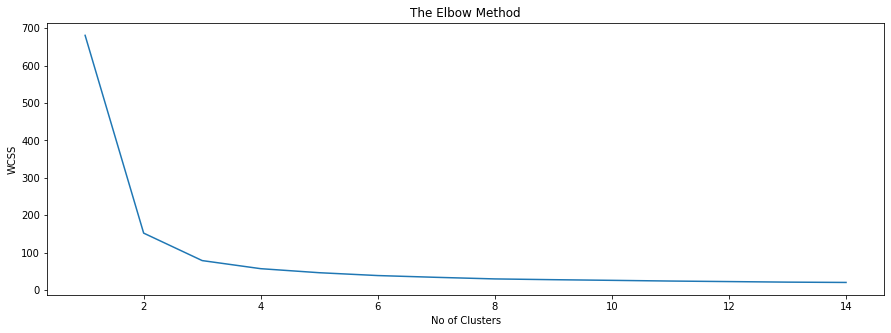

In [10]:
wcss = []

for i in range(1,15):
    kmean = KMeans(n_clusters=i,init="k-means++")
    kmean.fit_predict(no_labeled_data)
    wcss.append(kmean.inertia_)
    
plt.plot(range(1,15),wcss)
plt.title('The Elbow Method')
plt.xlabel("No of Clusters")
plt.ylabel("WCSS")
plt.show()

Как видно - оптимальным значением для размера кластера является - 2.

Проведите кластеризацию используя [пакетную кластеризацию k-средних](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html#sklearn.cluster.MiniBatchKMeans) . В чем
отличие от обычного метода k-средних. Постройте диаграмму рассеяния, на которой
будут выделено точки, которые для разных методов попали в разные кластеры


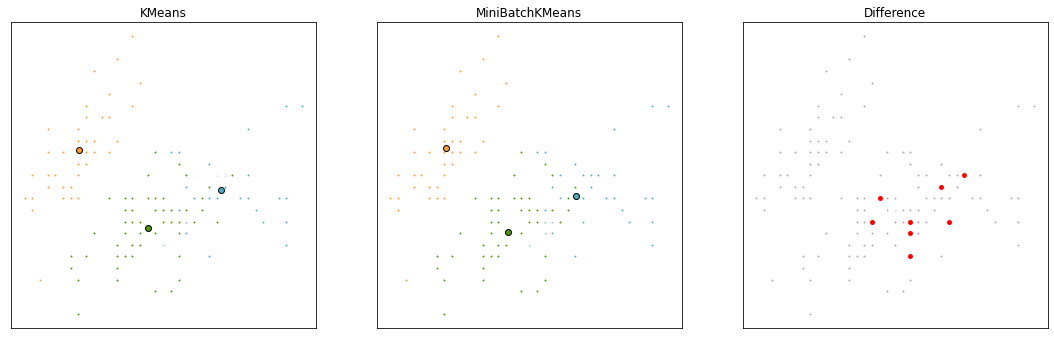

In [27]:
# import time

import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin

# #############################################################################
# Compute clustering with Means

k_means = KMeans(init='k-means++', n_clusters=3, n_init=10)
k_means.fit(no_labeled_data)

# #############################################################################
# Compute clustering with MiniBatchKMeans

mbk = MiniBatchKMeans(init='k-means++', n_clusters=3, batch_size=batch_size,
                      n_init=10, max_no_improvement=10, verbose=0)
mbk.fit(no_labeled_data)

# #############################################################################
# Plot result

fig = plt.figure()
fig.subplots_adjust(left=0.02, right=0.98, bottom=0.05, top=0.9)
colors = ['#4EACC5', '#FF9C34', '#4E9A06']

# We want to have the same colors for the same cluster from the
# MiniBatchKMeans and the KMeans algorithm. Let's pair the cluster centers per
# closest one.
k_means_cluster_centers = k_means.cluster_centers_
order = pairwise_distances_argmin(k_means.cluster_centers_,
                                  mbk.cluster_centers_)
mbk_means_cluster_centers = mbk.cluster_centers_[order]

k_means_labels = pairwise_distances_argmin(no_labeled_data, k_means_cluster_centers)
mbk_means_labels = pairwise_distances_argmin(no_labeled_data, mbk_means_cluster_centers)

# KMeans
ax = fig.add_subplot(1, 3, 1)
for k, col in zip(range(n_clusters), colors):
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    ax.plot(no_labeled_data[my_members][0], no_labeled_data[my_members][1], 'w',
            markerfacecolor=col, marker='.')
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
            markeredgecolor='k', markersize=6)
ax.set_title('KMeans')
ax.set_xticks(())
ax.set_yticks(())

# MiniBatchKMeans
ax = fig.add_subplot(1, 3, 2)
for k, col in zip(range(n_clusters), colors):
    my_members = mbk_means_labels == k
    cluster_center = mbk_means_cluster_centers[k]
    ax.plot(no_labeled_data[my_members][0], no_labeled_data[my_members][1], 'w',
            markerfacecolor=col, marker='.')
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
            markeredgecolor='k', markersize=6)
ax.set_title('MiniBatchKMeans')
ax.set_xticks(())
ax.set_yticks(())

# Initialise the different array to all False
different = (mbk_means_labels == 4)
ax = fig.add_subplot(1, 3, 3)

for k in range(n_clusters):
    different += ((k_means_labels == k) != (mbk_means_labels == k))

identic = np.logical_not(different)
ax.plot(no_labeled_data[identic][0], no_labeled_data[identic][1], 'w',
        markerfacecolor='#aaaaaa', marker='.')
ax.plot(no_labeled_data[different][0], no_labeled_data[different][1], 'w',
        markerfacecolor='r', marker='o')
ax.set_title('Difference')
ax.set_xticks(())
ax.set_yticks(())

plt.show()

Отличие пакетной от обычной кластеризации в том, что первая быстрее, так как при расчетах опирует случайной группой (batch) значений, а не каждой отдельно взятой точкой.

## Иерархическая кластеризация


Проведем иерархическую кластеризацию на тех же данных


In [28]:
from sklearn.cluster import AgglomerativeClustering

hier = AgglomerativeClustering(n_clusters=3, linkage='average')
hier = hier.fit(no_labeled_data)
hier_labels = hier.labels_


Отобразим результаты кластеризации


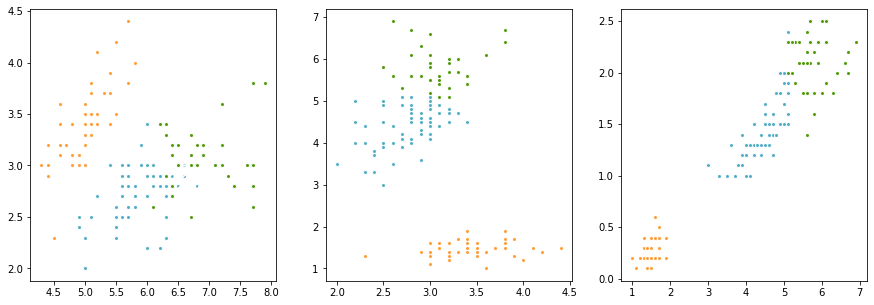

In [31]:
f, ax = plt.subplots(1, 3)

colors = ['#4EACC5', '#FF9C34', '#4E9A06']


for i in range(3):
    my_members = hier_labels == i
    for j in range(3):
        ax[j].plot(no_labeled_data[my_members][j],
        no_labeled_data[my_members][j+1], 'w',
        markerfacecolor=colors[i], marker='o', markersize=4)

        
plt.show()


В отличие от метода k-средних иерархическая кластеризация оперирует т.н. "Деревом кластеров", где корень - это все данные, а листья - единичные измерения. Агломеративная кластеризация строит дерево слиянием более маленьких кластеров, используя заданную стратегию - ward, average и др.


Проведём исследование для различного размера кластеров (от 2 до 5). 


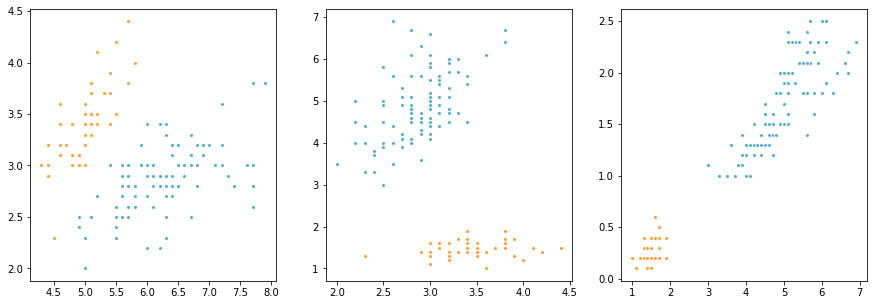

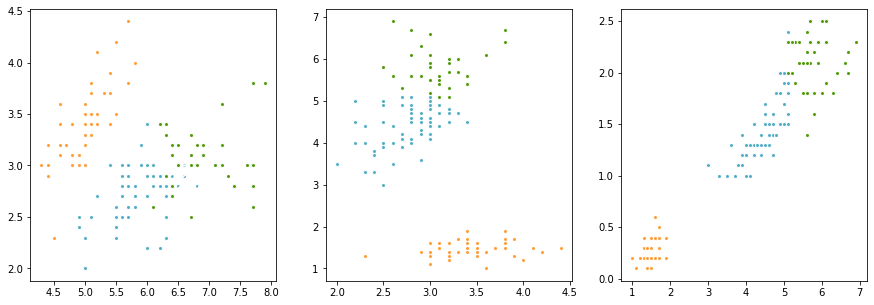

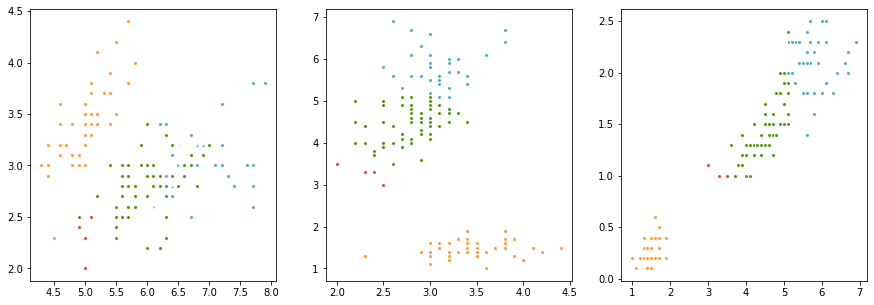

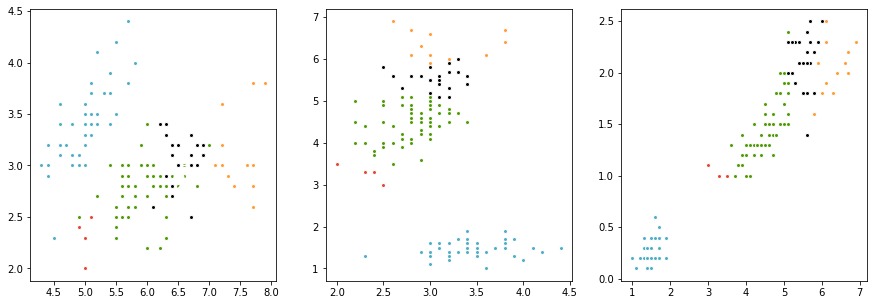

In [39]:
def test_cluster(n=2):
    hier = AgglomerativeClustering(n_clusters=n, linkage='average')
    hier = hier.fit(no_labeled_data)
    hier_labels = hier.labels_

    f, ax = plt.subplots(1, 3)

    colors = ['#4EACC5', '#FF9C34', '#4E9A06', '#e44332', '#000000']


    for i in range(n):
        my_members = hier_labels == i
        for j in range(3):
            ax[j].plot(no_labeled_data[my_members][j],
            no_labeled_data[my_members][j+1], 'w',
            markerfacecolor=colors[i], marker='o', markersize=4)

    plt.show()
    
test_cluster(2)
test_cluster(3)
test_cluster(4)
test_cluster(5)

Нарисуйте дендограмму до уровня 6


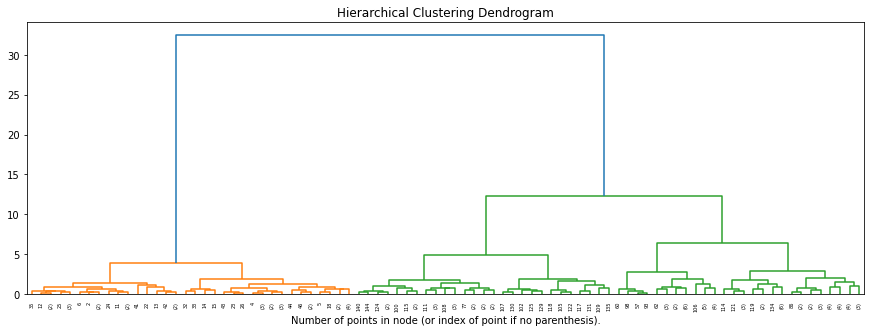

In [43]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

hier = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
hier = hier.fit(no_labeled_data)
    
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(hier, truncate_mode='level', p=6)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()


Сгенерируйте случайные данные в виде двух колец


In [44]:
import random
import math

data1 = np.zeros([250,2])
for i in range(250):
    r = random.uniform(1, 3)
    a = random.uniform(0, 2 * math.pi)
    data1[i,0] = r * math.sin(a)
    data1[i,1] = r * math.cos(a)

data2 = np.zeros([500,2])
for i in range(500):
    r = random.uniform(5, 9)
    a = random.uniform(0, 2 * math.pi)
    data2[i,0] = r * math.sin(a)
    data2[i,1] = r * math.cos(a)

data = np.vstack((data1, data2))


Проведите иерархическую кластеризацию


In [45]:
hier = AgglomerativeClustering(n_clusters=2, linkage='ward')
hier = hier.fit(data)
hier_labels = hier.labels_


Выведите полученные результаты


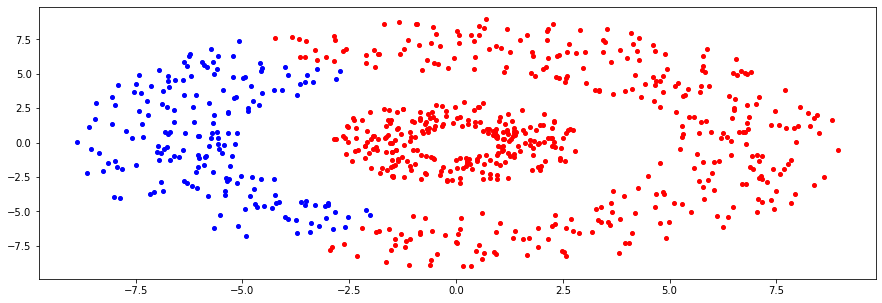

In [46]:
my_members = hier_labels == 0
plt.plot(data[my_members, 0], data[my_members, 1], 'w', marker='o',
markersize=4, color='red',linestyle='None')

my_members = hier_labels == 1
plt.plot(data[my_members, 0], data[my_members, 1], 'w', marker='o',
markersize=4, color='blue',linestyle='None')

plt.show()


Исследуйте кластеризацию при всех параметрах linkage. Отобразите и обоснуйте
полученные результаты. Для каких случаев, какой тип связи работает лучше всего.


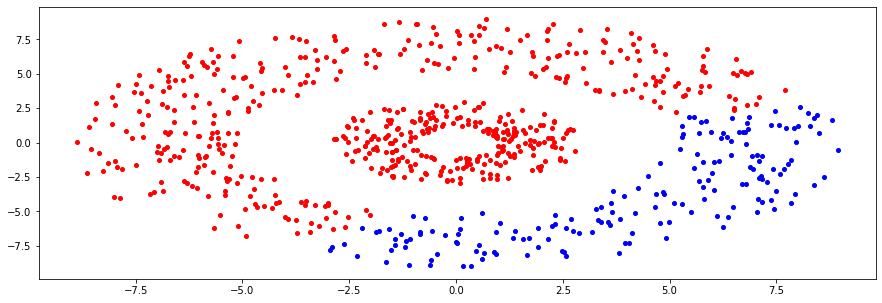

In [47]:
hier = AgglomerativeClustering(n_clusters=2, linkage='complete')
hier = hier.fit(data)
hier_labels = hier.labels_

my_members = hier_labels == 0
plt.plot(data[my_members, 0], data[my_members, 1], 'w', marker='o',
markersize=4, color='red',linestyle='None')

my_members = hier_labels == 1
plt.plot(data[my_members, 0], data[my_members, 1], 'w', marker='o',
markersize=4, color='blue',linestyle='None')

plt.show()

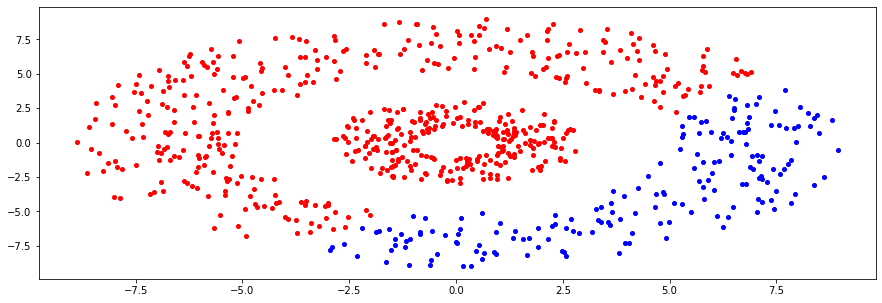

In [50]:
hier = AgglomerativeClustering(n_clusters=2, linkage='average')
hier = hier.fit(data)
hier_labels = hier.labels_

my_members = hier_labels == 0
plt.plot(data[my_members, 0], data[my_members, 1], 'w', marker='o',
markersize=4, color='red',linestyle='None')

my_members = hier_labels == 1
plt.plot(data[my_members, 0], data[my_members, 1], 'w', marker='o',
markersize=4, color='blue',linestyle='None')

plt.show()

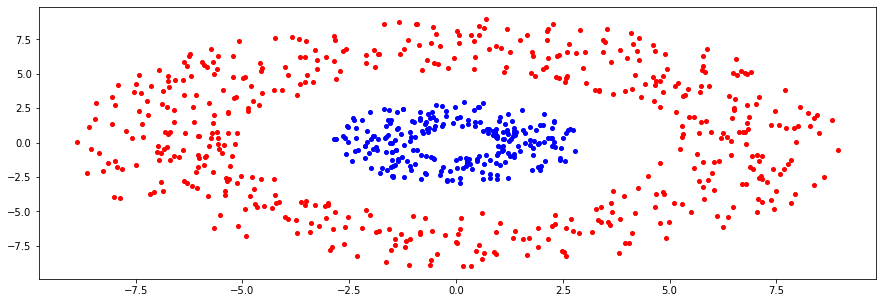

In [51]:
hier = AgglomerativeClustering(n_clusters=2, linkage='single')
hier = hier.fit(data)
hier_labels = hier.labels_

my_members = hier_labels == 0
plt.plot(data[my_members, 0], data[my_members, 1], 'w', marker='o',
markersize=4, color='red',linestyle='None')

my_members = hier_labels == 1
plt.plot(data[my_members, 0], data[my_members, 1], 'w', marker='o',
markersize=4, color='blue',linestyle='None')

plt.show()

Как видно, для двух колец больше подошел метод линковки 'single'. 

- ward минимизирует дисперсию двух сливаемых кластеров
- average использует среднее расстояний каждого наблюдения в двух кластерах
- complete испольует максимум расстояний между всеми наблюдениями в двух кластерах
- single испольует минимум расстояний между всеми наблюдениями в двух кластерах

Single хорошо подходит для кластеров не шарообразной формы, а также для больших датасетов (так как работает быстро).
Ward лучше использовать для кластеров более-менее одинаковых размеров. 